# Вебинар 4. Обучение с учителем.

**План занятия**
* [Введение](#intro)
* [Шаг 1. Загрузка данных](#load)
* [Шаг 2. EDA и очистка данных](#eda)
* [Шаг 3. Разбиение на train / test](#split)
* [Шаг 4: Предобработка данных и Feature engineering](#preprocess)
* [Шаг 5. Построение моделей](#model)
    * [5.1 Linear Regression](#linear)
    * [5.2 Decision tree](#tree)
    * [5.3 Random Forest](#rf)
    * [5.4 Gradient Boosting decision trees](#boost)
* [Шаг 6. Настройка и оценка финальной модели](#cross_val)
* [Шаг 7. Анализ прогнозов](#pred)
* [Шаг 8. Сохранение модели](#save)
* [Обобщение](#full)

## Введение <a class='anchor' id='intro'>

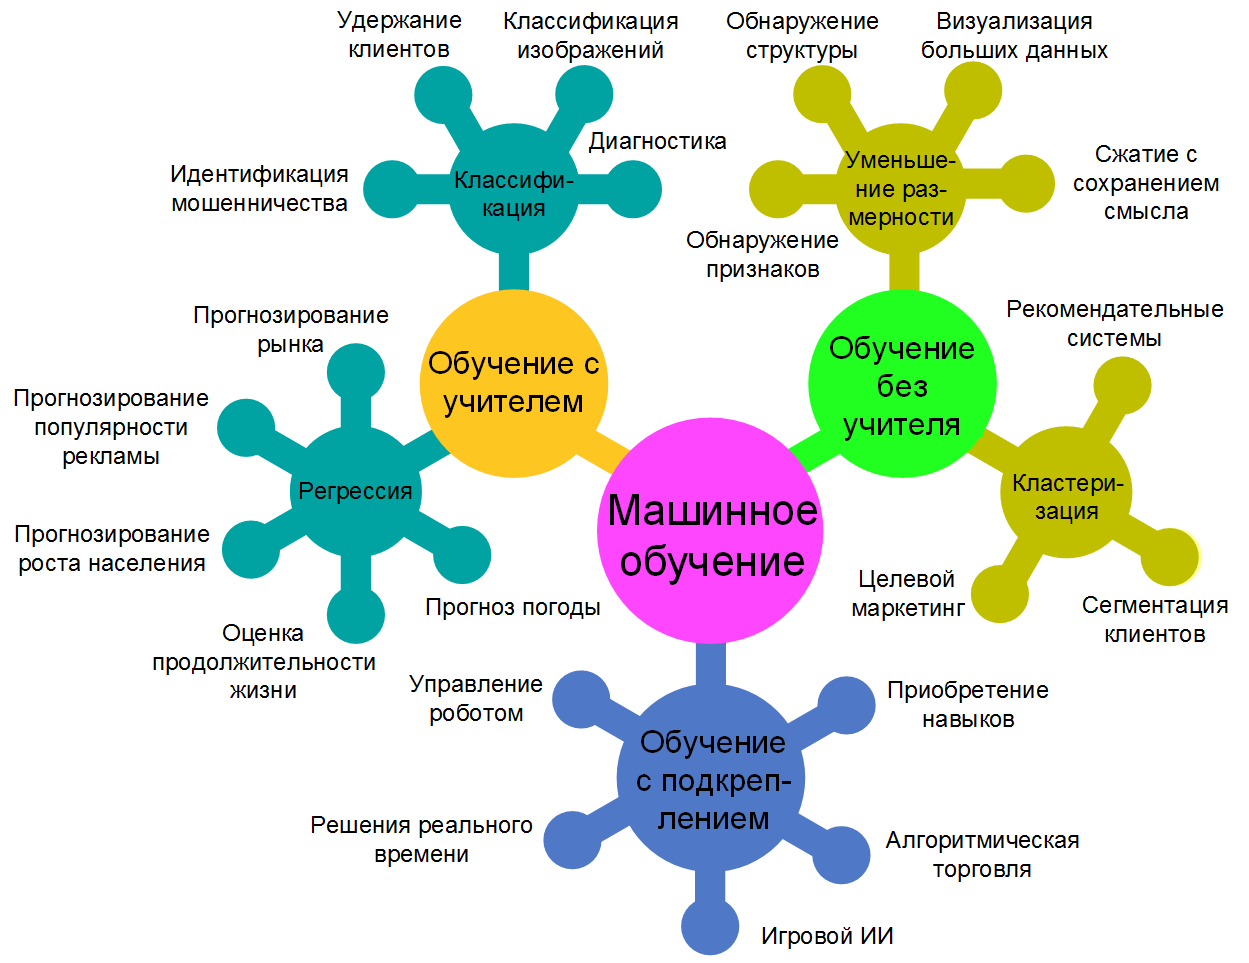 

**Обучение с учителем** = есть целевая переменная (таргет), которую мы предсказываем

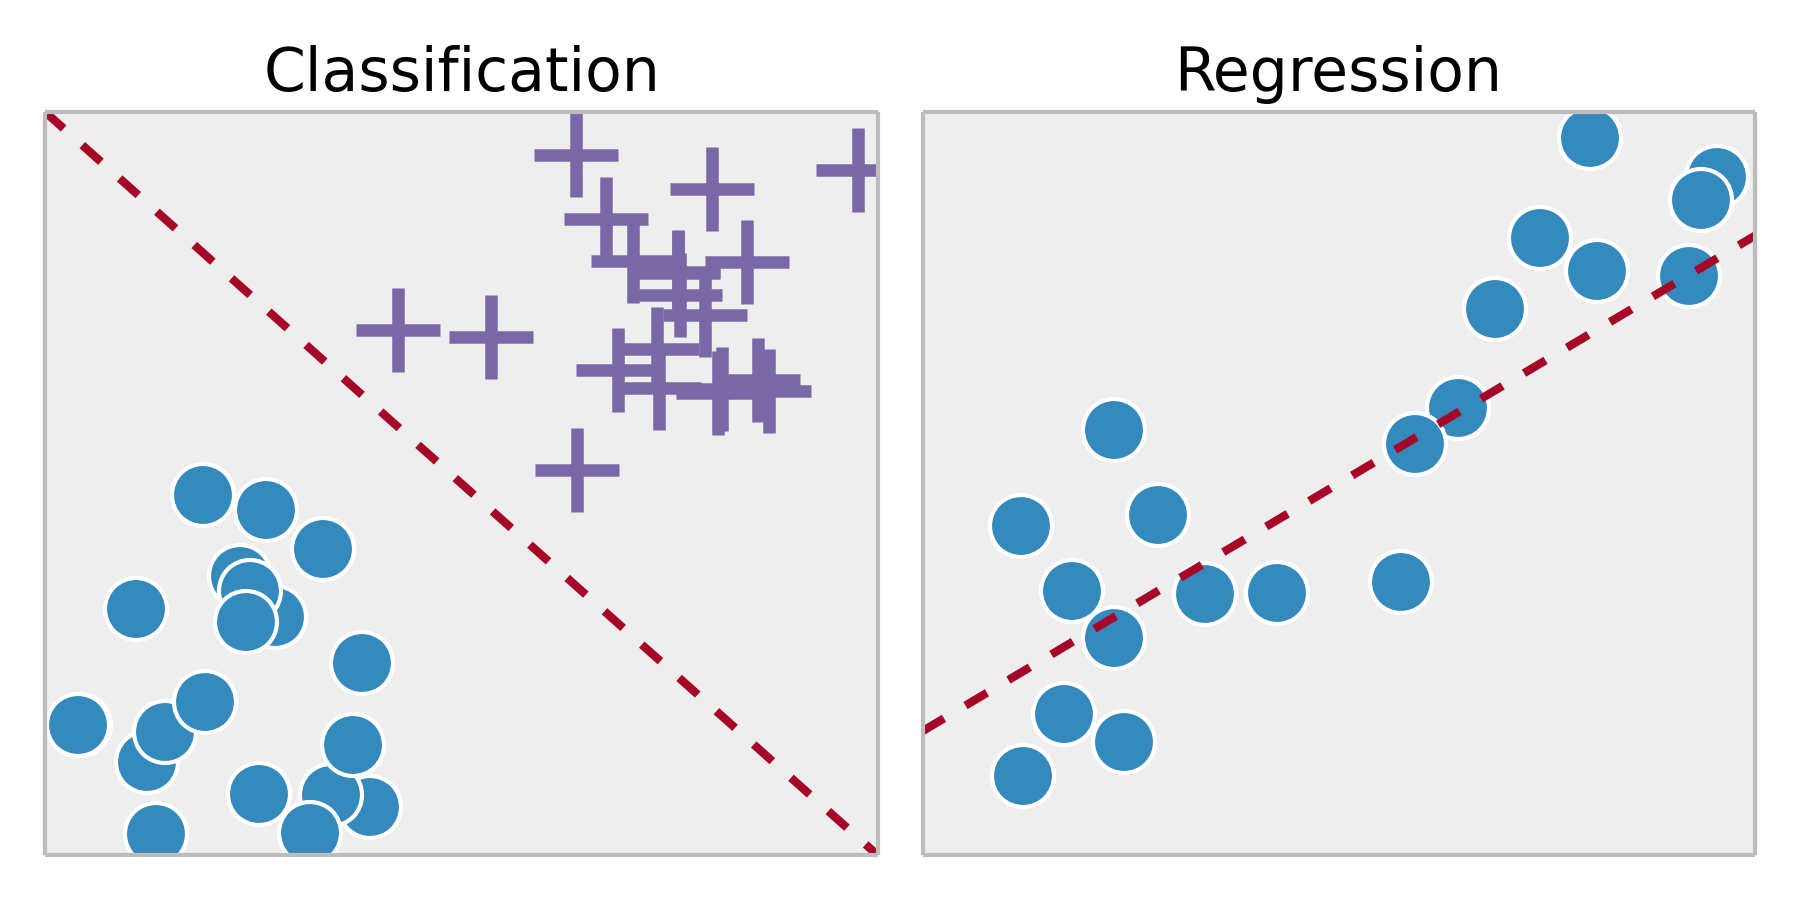

_Регрессия_ - таргет непрерывен
- Предсказание цен на дома
- Предсказание спроса на товары
- ...


_Классификация_ - Таргет принимает 2 (иногда k) значений
- Кредитный скоринг: вернет кредит (target=0) или нет (target=1)
- Определение вида животного по фото (0 - лев, 1 - пантера, 2 - леопард, ... , k - гепард) 
- ...

**Обучение без учителя** = нет целевой переменной:
- Разделение данных на группы
- ...
_______________

**Обучение с подкреплением** - испытуемая система (агент) обучается, взаимодействуя с некоторой средой.
<table><tr>
<td> <img src="images/openai1.gif" style="width: 600px;"/> </td>
<td> <img src="images/unnamed.gif" style="width: 450px;"/> </td>
</tr></table>

_________
**Что относится к классификации?**<br>
1. Прогноз оценки студента по пятибалльной шкале на экзамене 
2. Предсказание спроса на товары
3. Поиск похожих групп пользователей
4. Разделение книг на художественные и научные

---

**ЭТАПЫ Data Science проекта:**
1. Определить бизнес проблему
2. Перевести бизнес проблему в ML-задачу
3. Выбрать подходящие ML и бизнес метрики
---------------------------------------------------------------------------
4. Загрузка данных
5. EDA: визуализация данных (вебинар 3)
6. **_Разбиение данных на train и test_**
7. Предобработка данных и feature engineering (вебинар 2)
8. **_Построение ML моделей_**
9. **_Оценка качества ML моделей и выбор наилучшей_**

---------------------------------------------------------------------------
10. Доказать бизнес-заказчику, что модель хорошо работает
11. Внедрение модели в production
12. Улучшение модели
13. Поддержка модели

---

**Подключение библиотек и скриптов**

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [3]:
DATASET_PATH = './data/housing.csv'
PREPARED_DATASET_PATH_TRAIN = './data/housing_prepared_train.csv'
PREPARED_DATASET_PATH_TEST = './data/housing_prepared_test.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

# Шаг 1. Загрузка данных <a class='anchor' id='load'>

По **reduce_mem_usage** смотри вебинар 3

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [5]:
df = pd.read_csv(DATASET_PATH, sep=';')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2.83 MB
Memory usage after optimization is: 1.06 MB
Decreased by 62.5%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_rooms
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,14.659091,0.365909,0,0,0,1,0,2083.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,15.579659,0.338217,0,0,0,1,0,2083.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,12.951602,0.338105,0,0,0,1,0,2083.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,18.445839,0.437991,0,0,0,1,0,2083.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,17.209589,0.347265,0,0,0,1,0,2083.0


In [6]:
df.dtypes

longitude               float32
latitude                float32
housing_median_age      float32
total_rooms             float32
total_bedrooms          float32
population              float32
households              float32
median_income           float32
median_house_value      float32
ocean_proximity        category
bedroom_share           float32
population_per_room     float32
<1H OCEAN                  int8
INLAND                     int8
ISLAND                     int8
NEAR BAY                   int8
NEAR OCEAN                 int8
median_rooms            float32
dtype: object

# Шаг 2. EDA и очистка данных  <a class='anchor' id='eda'>

*В этом вебинаре мы не будем останавливаться на EDA, но в проекте это сделать нужно - __смотри вебинар 3__

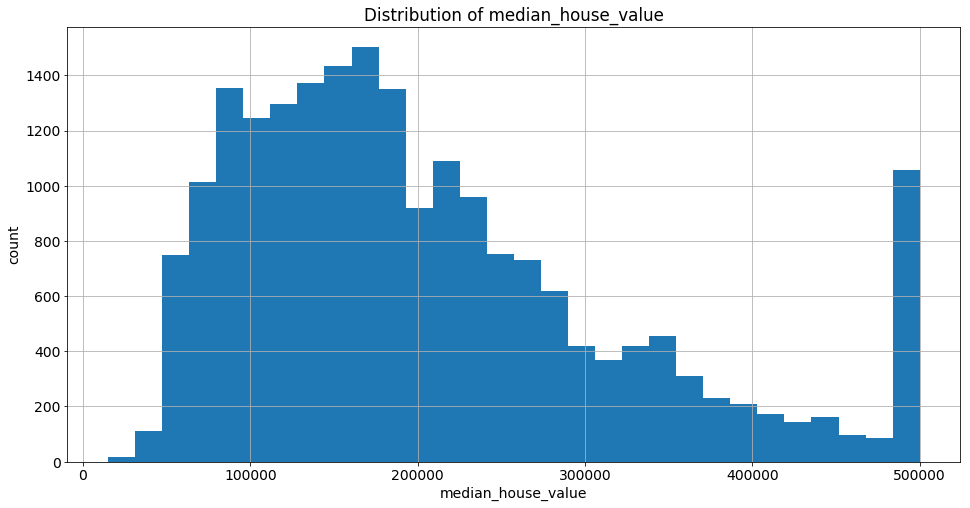

In [7]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [8]:
df = df[df['median_house_value'] <= 500000].reset_index()

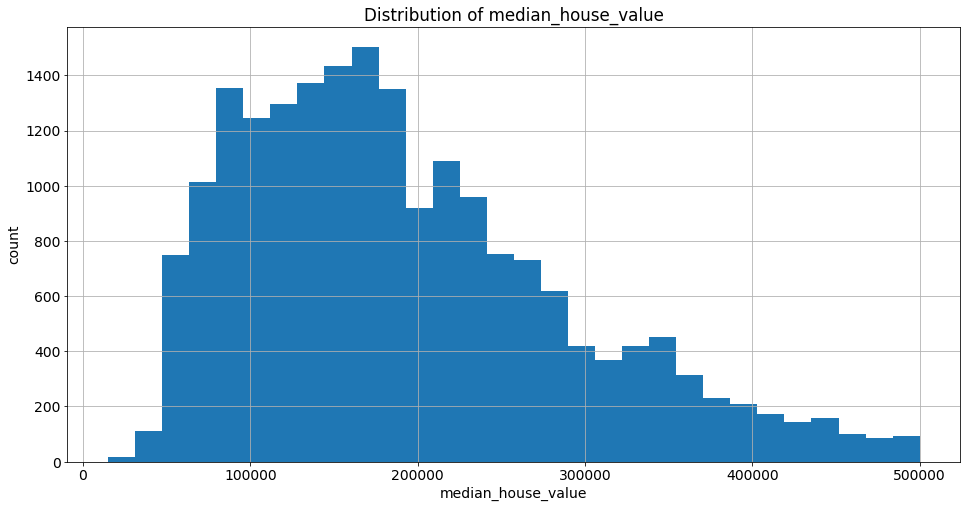

In [9]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

# Шаг 3. Разбиение на train / test  <a class='anchor' id='split'>

In [12]:
# np.random.seed(11)
# np.random.randint(0, 10, 5)

In [11]:
X = df.drop(columns='median_house_value')
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)
X_train.index

Int64Index([10760, 11067, 12232,  7331,  2572,  8314,  5794,  3854,  8856,
            17386,
            ...
             7906, 13890, 10082, 14260, 16734, 16304,    79, 12119, 14147,
             5640],
           dtype='int64', length=13182)

# Шаг 4: Предобработка данных и Feature engineering  <a class='anchor' id='preprocess'>

*Пример вы можете посмотреть в вебинаре 2: __class DataPipeline__

In [13]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.longitude_median = None
        self.latitude_median = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['population', 'housing_median_age', 'total_bedrooms']].median()
        self.longitude_median = df['longitude'].median()
        self.latitude_median = df['latitude'].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['population', 'housing_median_age', 'total_bedrooms']] =\
            df[['population', 'housing_median_age', 'total_bedrooms']].fillna(self.medians)
        
        
        # 2. Выбросы (outliers)
        df.loc[df['longitude'] > 0, 'longitude'] = df.loc[df['longitude'] > 0, 'longitude'] * -1
        df.loc[df['longitude'] == 0, 'longitude'] = self.longitude_median
        df.loc[(df['latitude'] <= 0) | (df['latitude'] > 50), 'latitude'] = self.latitude_median
        
        
        # 3. Новые фичи (features)
        
        # Доля спален в общем кол-ве комнат
        df['bedroom_share'] = df['total_bedrooms'] / df['total_rooms'] * 100

        # Сколько человек в среднем живут в одной комнате
        df['population_per_room'] = df['population'] / df['total_rooms']
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)
        
        return df

In [14]:
pipe = DataPipeline()
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

---

**Оставим признаки, которые необходимы для модели**

In [15]:
X_train.columns.tolist()

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity',
 'bedroom_share',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_rooms',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [16]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [17]:
X_train = X_train[feature_names]
X_test = X_test[feature_names]

X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,<1H OCEAN,INLAND,INLAND,NEAR BAY,NEAR BAY,NEAR OCEAN,NEAR OCEAN
10760,-121.760002,37.669998,6.0,3023.0,518.0,1225.0,468.0,6.3705,0,0,1,1,0,0,0,0
11067,-121.900002,38.029999,51.0,2982.0,689.0,1831.0,608.0,2.0034,0,0,1,1,0,0,0,0
12232,-119.250000,35.750000,36.0,1598.0,443.0,1658.0,417.0,1.5170,0,0,1,1,0,0,0,0
7331,-117.790001,33.880001,17.0,8562.0,1351.0,3822.0,1316.0,6.0829,1,1,0,0,0,0,0,0
2572,-118.360001,34.180000,36.0,2233.0,605.0,1934.0,599.0,2.8784,1,1,0,0,0,0,0,0


**Стандартизация признаков** 

In [18]:
feature_names_for_stand = X_train.select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

**Нормализация** - MinMaxScaler() Для каждой фичи x делает:
$$\frac{x_i - min}{max - min}$$
После нормализации признак будет изменяться в диапазоне [0, 1].<br>
Лучше зарекомендовала себя в моделях, которые работают с расстояниями (KNN).

<br>

**Стандартизация** - StandardScaler(). Для каждой фичи х делает:
$$\frac{x - mean}{std}$$
После стандартизации у признака будут mean = 0, std = 1.<br>
Лучше зарекомендовала себя в линейных моделях.

In [19]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_test = scaler.transform(X_test[feature_names_for_stand])

In [20]:
stand_features_train

array([[-1.0917501 ,  0.9305808 , -1.8176877 , ..., -0.17418489,
        -0.07764188,  1.7242891 ],
       [-1.1615183 ,  1.0975882 ,  1.8392029 , ...,  0.35937312,
         0.29125875, -1.0633425 ],
       [ 0.15910208,  0.03987741,  0.6202393 , ...,  0.20705374,
        -0.21202713, -1.373824  ],
       ...,
       [ 0.27372357, -0.15032499,  0.78276783, ..., -0.6434694 ,
        -0.5334977 , -0.8660361 ],
       [-0.9621788 ,  1.3480991 ,  1.3516175 , ..., -0.80371284,
        -0.7838231 , -1.6965613 ],
       [ 0.7022986 , -0.79979753,  0.29518238, ..., -0.13456425,
        -0.03548181,  0.7031597 ]], dtype=float32)

In [21]:
X_train[feature_names_for_stand] = stand_features_train
X_test[feature_names_for_stand] = stand_features_test

In [22]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,<1H OCEAN,INLAND,INLAND,NEAR BAY,NEAR BAY,NEAR OCEAN,NEAR OCEAN
10760,-1.091750,0.930581,-1.817688,0.195203,-0.041954,-0.174185,-0.077642,1.724289,0,0,1,1,0,0,0,0
11067,-1.161518,1.097588,1.839203,0.176212,0.366623,0.359373,0.291259,-1.063342,0,0,1,1,0,0,0,0
12232,0.159102,0.039877,0.620239,-0.464847,-0.221154,0.207054,-0.212027,-1.373824,0,0,1,1,0,0,0,0
7331,0.886688,-0.827631,-0.923781,2.760830,1.948365,2.112366,2.156842,1.540707,1,1,0,0,0,0,0,0
2572,0.602631,-0.688459,0.620239,-0.170720,0.165919,0.450060,0.267544,-0.504808,1,1,0,0,0,0,0,0


### Сохранение  датасета

In [23]:
X_train.to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, encoding='utf-8', sep=';')
X_test.to_csv(PREPARED_DATASET_PATH_TEST, index=False, encoding='utf-8', sep=';')

# Шаг 5. Построение моделей <a class='anchor' id='model'>

    
ML метрика - Mean Squared Error (**MSE**) 
    - MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей



Бизнес метрика - **R^2**, Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - насколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели

Лучшая модель - модель с наименьшей MSE на test 

 $$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\frac{1}{n}\sum{(y - y_{pred})^2}}{\frac{1}{n}\sum{(y - y_{mean})^2}}$$

In [24]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.1 Linear Regression  <a class='anchor' id='linear'>

<img src='images/linear_reg.png' width=500px>

In [ ]:
y = ax + b

$$price_{pred} = a_0 + a_1 * households + a_2 * rooms$$

Подробное объяснение [здесь](https://codecamp.ru/blog/introduction-to-linear-regression-python/)

$$Loss = MSE = \frac{1}{n}\sum{(price - price_{pred})^2}$$

$$Loss = MSE = \frac{1}{n}\sum{(price - (a_0 + a_1 * households + a_2 * rooms))^2}$$

$dx^2 = 2x$

$d4x = 4$

Находим производные по параметрам и решим систему из 3 уравнений с 3 неизвестными:

$$\frac{dLoss}{da_0} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * 1} = 0 $$  
$$\frac{dLoss}{da_1} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * households} = 0 $$  
$$\frac{dLoss}{da_2} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * rooms} = 0 $$  

In [25]:
np.clip([-10, 1, 100000, 1000000], a_min=10000, a_max=500000)

array([ 10000,  10000, 100000, 500000])

R2:	0.61
RMSE:	61009.439
MSE:	3722151680.836


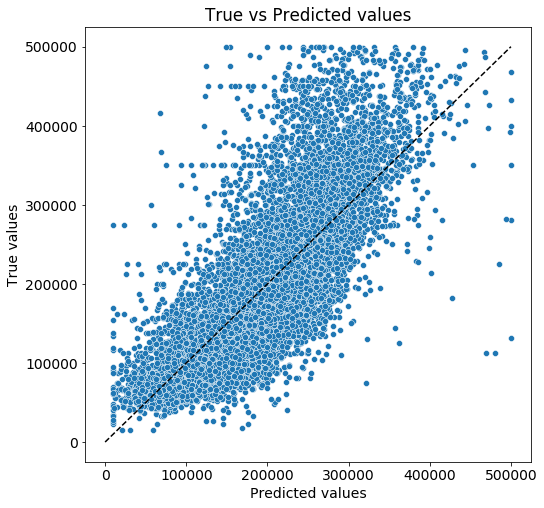

In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.614
RMSE:	60768.926
MSE:	3692862347.041


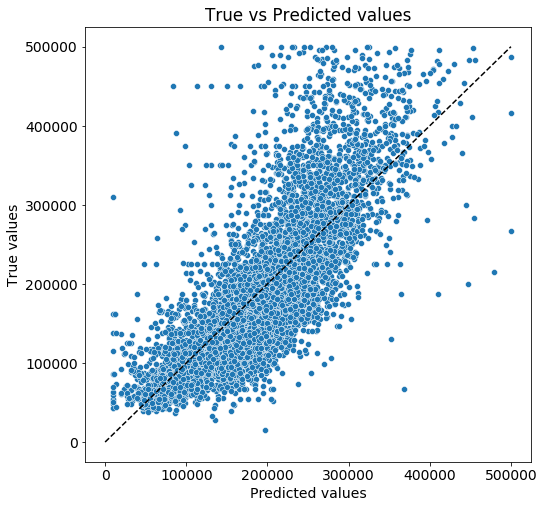

In [27]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

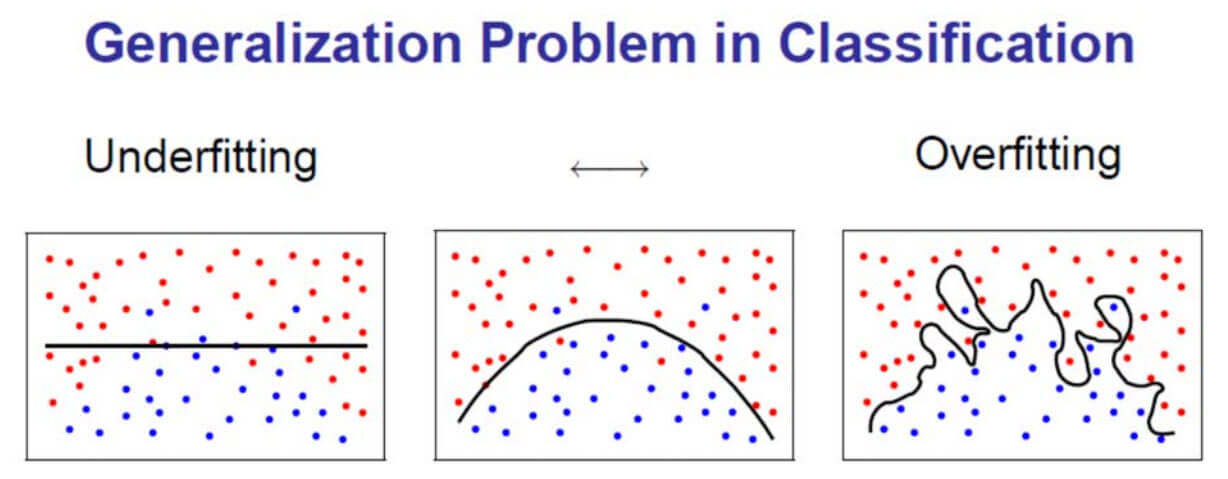

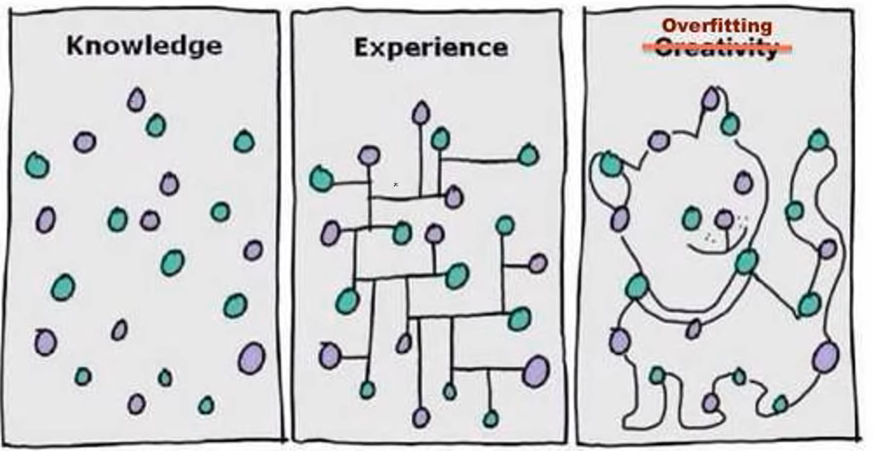

### 5.2 Decision tree  <a class='anchor' id='tree'>

Подробнее можно почитать [здесь](https://habr.com/ru/company/ods/blog/322534/)

На примере задачи: _Сколько времени человек потратит на онлайн игры?_  (0 - 24 часа/день)

<img src='images/dt_explained.png'>

- age < 15 and is_male > 0.5 ---> 5
- age < 15 and is_male <= 0.5 ---> 0
- age >= 15 ---> 1

Decision tree может моделировать зависимости такого вида:

<img src='images/dt_example.png'>

R2:	0.686
RMSE:	54754.421
MSE:	2998046630.471


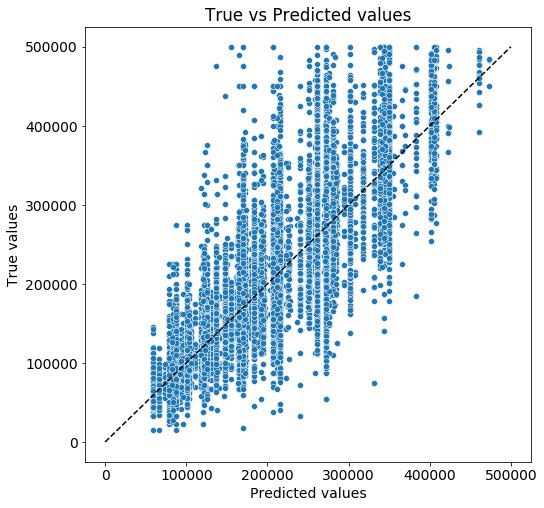

In [28]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=7, # глубина дерева  
                                 min_samples_leaf=3, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.631
RMSE:	59378.337
MSE:	3525786900.396


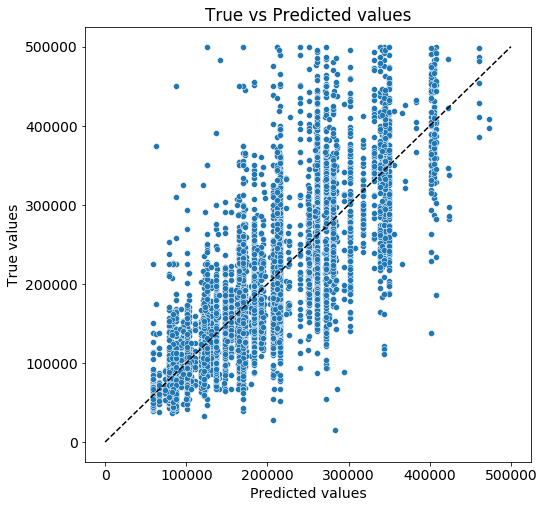

In [29]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

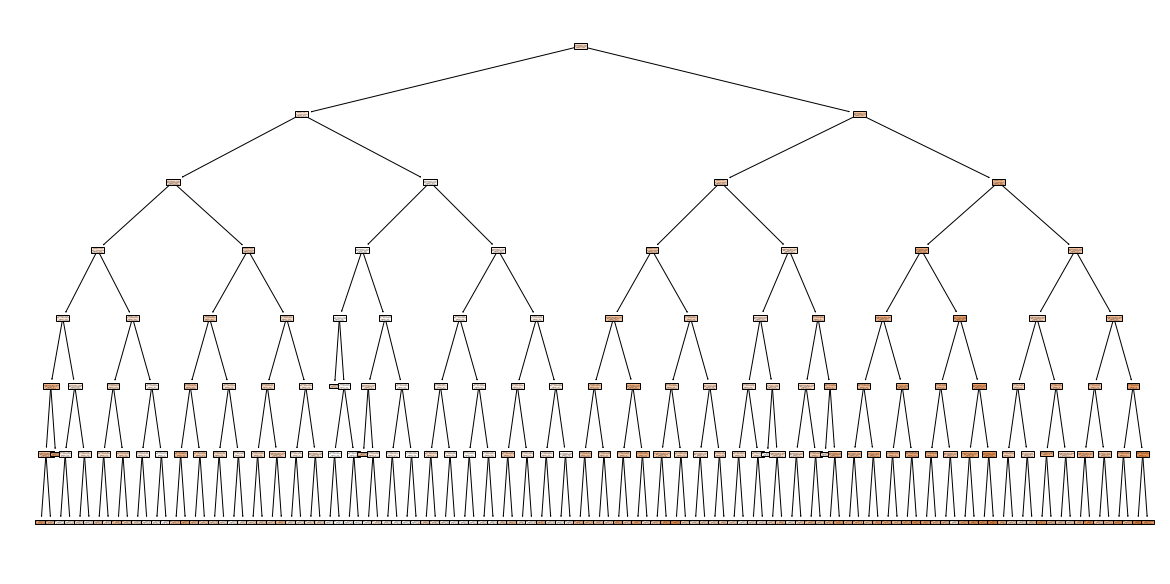

In [28]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True);

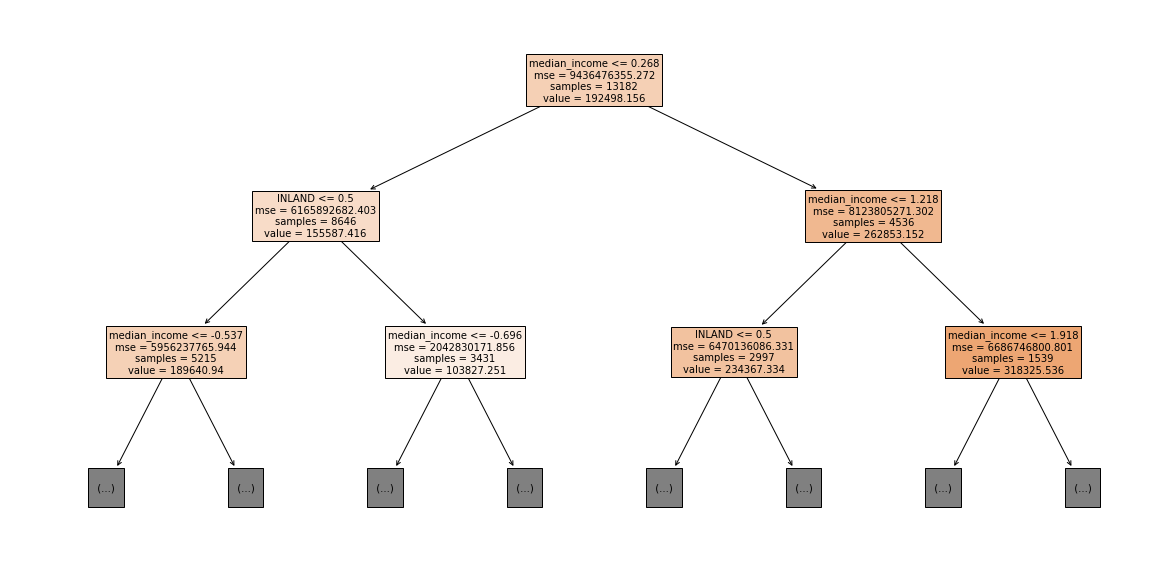

In [28]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True, max_depth=2);

### 5.3 Random Forest  <a class='anchor' id='rf'>

Про лес подробнее можно почитать [здесь](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

**Независимо** строятся N деревьев. Их **предсказания усредняются**

Чтобы деревья получались разными добавляют элемент случайности:
- каждое дерево строят на подвыборке данных (случайно сэмплируют 70% данных)
- каждое дерево строят на подвыборке фич (случайно сэмплируют 70% фич)
- ...

<img src='images/rf_explained.png'>

Бутстрэп - выбираем из обучающей выборки k объектов с возвращением.
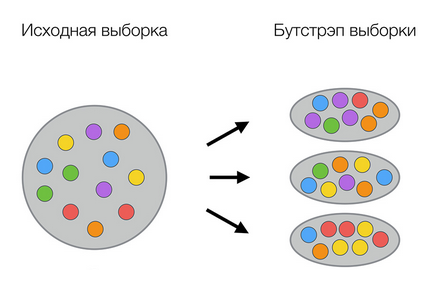
Бэггинг - Бутстрэп-агрегирование<br>
Про бэггинг и бутстрэп можно почитать [здесь](https://habr.com/ru/company/ods/blog/324402/)

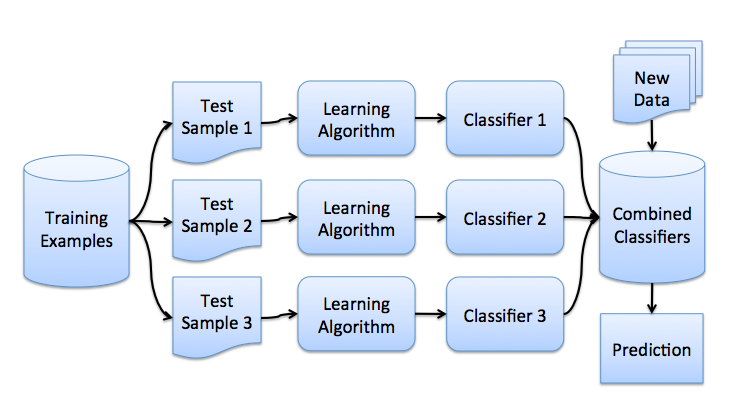

R2:	0.766
RMSE:	47283.785
MSE:	2235756278.119


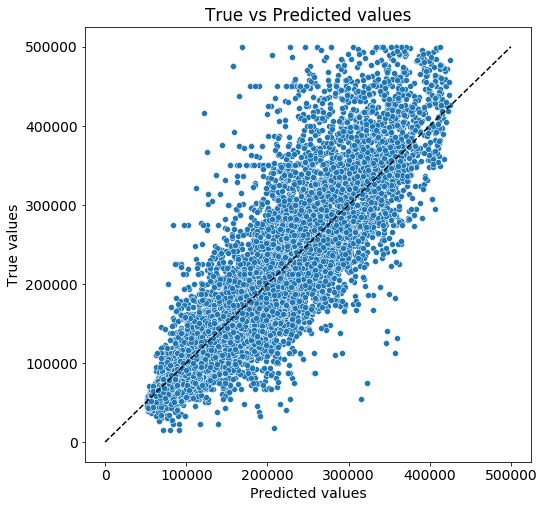

In [30]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.729
RMSE:	50906.086
MSE:	2591429593.331


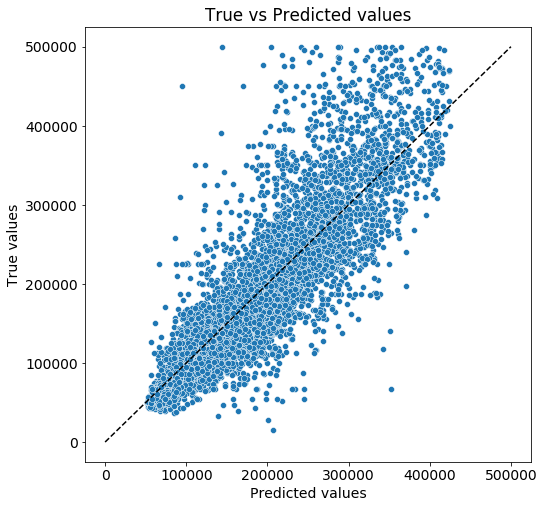

In [31]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4 Gradient Boosting decision trees  <a class='anchor' id='boost'>

Подробнее можно почитать [здесь](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

**Последовательно** строятся N деревьев: новое дерево обучается на ошибках предыдущих. **Предсказания деревьев суммируются**

<img src='images/gb_explained.png'>

In [32]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [33]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.7025

In [34]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])


gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.905

In [35]:
error_2 = y - gb_pred
error_2

array([ 1, -1, -2, -4,  4])

In [36]:
# Третье дерево: таргет = ошибки предыдущих (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.95

In [37]:
error_3 = y - gb_pred
error_3

array([ 1,  0, -1, -3,  3])

---

R2:	0.889
RMSE:	32504.598
MSE:	1056548892.015


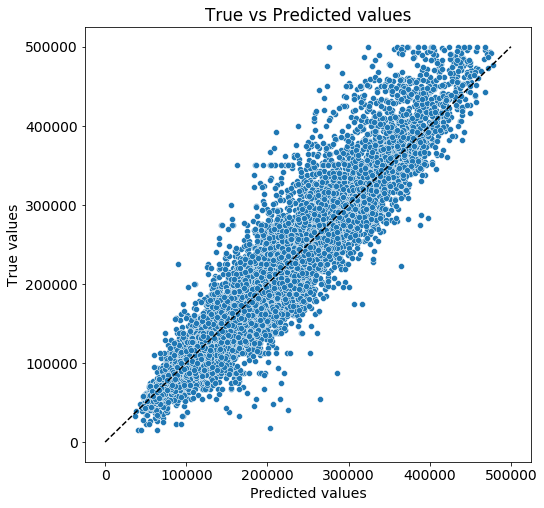

In [38]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.803
RMSE:	43404.987
MSE:	1883992931.278


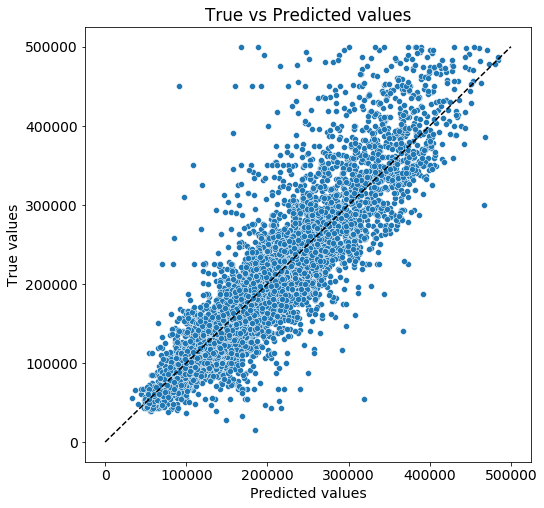

In [39]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Шаг 6.* Настройка и оценка финальной модели  <a class='anchor' id='cross_val'>

!!!  кросс-валидация проходит на трейне, test не трогаем  !!!

[Кросс валидация](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85) и подбор гиперпараметров

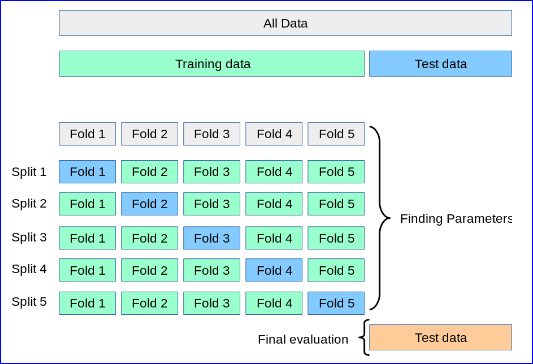

In [51]:
X_train.shape[0] // 5

2636

In [52]:
X_train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)

In [ ]:
# Одну модель (одни и те же гиперпараметры)

# Iteration_1
X_train__val_1 = X_train.iloc[:2500]
y_train__val_1 = y_train.iloc[:2500]

X_train__train_1 = X_train.iloc[2500:]
y_train__train_1 = y_train.iloc[2500:]


# обучаем модель на X_train__train_1, y_train__train_1
# предсказываем на X_train__val_1, y_train__val_1
# R2__1 = r2(y_pred__val_1, y_train__val_1) = 0.83


# Iteration_2
X_train__val_2 = X_train.iloc[2500:5000]
y_train__val_2 = y_train.iloc[2500:5000]

X_train__train_2 = X_train.drop(np.arange(2500, 5000))
y_train__train_2 = y_train.drop(np.arange(2500, 5000))


# обучаем модель на X_train__train_2, y_train__train_2
# предсказываем на X_train__val_2, y_train__val_2
# R2__2 = r2(y_pred__val_2, y_train__val_2) = 0.87


# ...

# R2 = [0.83, 0.87, 0.79, 0.8, 0.91]

In [53]:
R2 = np.array([0.83, 0.87, 0.79, 0.8, 0.91])
np.mean(R2)

0.8400000000000001

In [ ]:
# Сделали то же самое для модели с другими гиперпараметрами

In [ ]:
# cross val R2 model_1 = 0.84
# cross val R2 model_2 = 0.87 - выбираем эту модель (ее гиперпараметры)

In [ ]:
# ЗАНОВО Обучаем модель с наилучшими гиперпараметрами (те, которые дают максимальный cross val R2) на ВСЕМ train

---

In [48]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=65,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [55]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: user 39.7 s, sys: 119 ms, total: 39.8 s
Wall time: 7min 30s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [56]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.932978,0.429049,0.027261,0.009814,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.672453,0.693378,0.680593,0.690541,0.660996,0.679592,0.011897,16
1,7.246042,0.632607,0.023156,0.006583,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.725435,0.747829,0.731086,0.745777,0.713352,0.732696,0.012881,15


In [57]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [58]:
gs.best_score_

0.805223305161466

**Обучение и оценка модели**

In [39]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

R2:	0.952
RMSE:	21350.587
MSE:	455847556.339


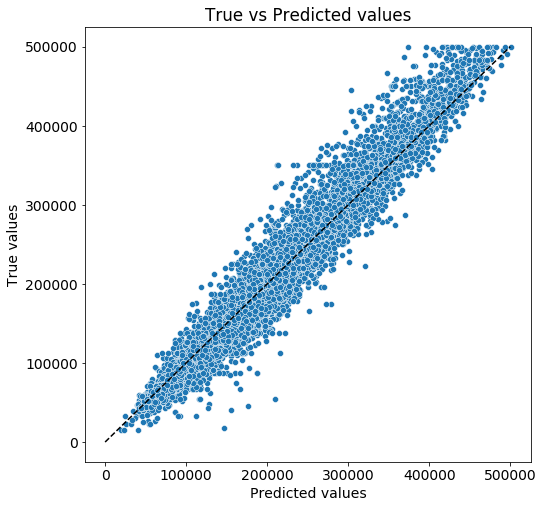

In [40]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.812
RMSE:	42380.746
MSE:	1796127623.485


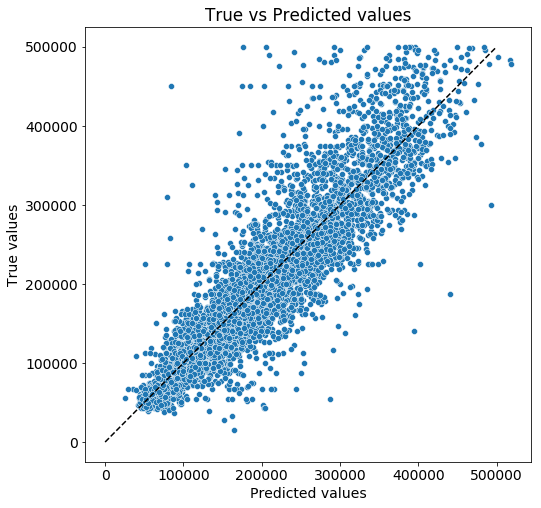

In [41]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

# Шаг 7.* Анализ прогнозов <a class='anchor' id='pred'>

**Важность признаков**

In [42]:
final_model.feature_importances_

array([0.11464422, 0.1186939 , 0.040407  , 0.02833925, 0.02621289,
       0.03932132, 0.02035803, 0.43084499, 0.00320871, 0.17115536,
       0.00157433, 0.00524001])

In [43]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

**Топ-3 фичи**

In [44]:
feature_importances.head(3)

,feature_name,importance
7,median_income,0.430845
9,INLAND,0.171155
1,latitude,0.118694


**Худшие 3 фичи**

In [45]:
feature_importances.tail(3)

,feature_name,importance
11,NEAR OCEAN,0.005240
8,<1H OCEAN,0.003209
10,NEAR BAY,0.001574


In [46]:
feature_importances.to_csv(REPORTS_FILE_PATH + 'feature_importances.csv', index=False)

# Шаг 8. Сохранение модели <a class='anchor' id='save'>

In [47]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [48]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [49]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

In [50]:
import sklearn
print(sklearn.__version__)

0.23.2


In [51]:
pip freeze

absl-py==0.8.1
aiocontextvars==0.2.2
aiohttp==3.6.2
amqp==2.5.2
apriori==1.0.0
apyori==1.1.2
astor==0.8.0
async-timeout==3.0.1
attrs==20.2.0
backcall==0.1.0
beautifulsoup4==4.8.1
billiard==3.6.1.0
bleach==1.5.0
bs4==0.0.1
cachetools==4.1.1
catboost==0.24.1
celery==4.3.0
certifi==2020.6.20
cffi==1.13.2
chardet==3.0.4
Click==7.0
click-plugins==1.1.1
cligj==0.5.0
cloudpickle==1.6.0
confuse==1.3.0
contextvars==2.4
cryptography==2.8
cycler==0.10.0
Cython==0.29.15
dask==2.30.0
decorator==4.4.0
defusedxml==0.6.0
distributed==2.30.0
Django==2.2.5
entrypoints==0.3
et-xmlfile==1.0.1
featuretools==0.20.0
Fiona==1.8.13.post1
fire==0.2.1
Flask==1.1.1
flirimageextractor==1.4.0
fluent-logger==0.9.4
fsspec==0.8.4
future==0.18.2
gast==0.2.2
geopandas==0.8.0
google-auth==1.23.0
google-auth-oauthlib==0.4.2
google-pasta==0.2.0
graphviz==0.14.1
grpcio==1.23.0
grpcio-tools==1.23.0
gunicorn==20.0.0
h5py==2.10.0
HeapDict==1.0.1
html5lib==0.9999999
htmlmin==0.1.12
hyperopt==0.2.3
idna==2.8
idna-ssl==1.1.0
imag

# Обобщение  <a class='anchor' id='full'>

----

## $$Метрики$$
<img src='images/classif&regr.png'>

In [72]:
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

x = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
y = [0, 10, 15]
knn = KNeighborsRegressor(n_neighbors=1)
c = BaggingRegressor(knn, base_estimator=100)
c.fit(x, y)
c.predict(x)

array([5., 5., 5.])

[Машинное обучение для людей](https://zen.yandex.ru/media/id/5c228ab268a70a00adaf792a/mashinnoe-obuchenie-dlia-liudei-5c23782132121100a94a4417)
<img src=https://avatars.mds.yandex.net/get-zen_doc/1056701/pub_5c23782132121100a94a4417_5c2378bab8997d00a95fbbcc/scale_2400 width=800px>

___________
<img src='images/ds_pipeline.png'>

## Курсовая
**Требования к курсовому:**

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)


________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


*Что обязательно стоит попробовать:*
1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

*Что можно попробовать:*
1. Кластеризация
2. Модели понижения размерности